In [19]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import pandas as pd
import scipy.special as special
import random

In [20]:
#cd D:\ThisSemester\CompNeuro\Homeworks\Hw3\HW3_Can_Kocagil\Assignment

D:\ThisSemester\CompNeuro\Homeworks\Hw3\HW3_Can_Kocagil\Assignment


### Question 1

In [21]:
f = h5py.File('hw3_data2.mat','r')

X = np.array(f.get('Xn')).T

y = np.array(f.get('Yn')).flatten()
    
print(X.shape,y.shape)

(1000, 100) (1000,)


In [22]:
def random_seed(seed:int = 42) -> None :
    """ Random seeding for reproducebility 
    
            Arguments:
                - seed (int) : random state

            Returns:
                - None
    
    """
    np.random.seed(seed)
    random.seed(seed)

In [23]:
class RidgeRegression(object):
    
    """
        Ridge regression is a method of estimating the coefficients of multiple-regression models in
        scenarios where independent variables are highly correlated. 

    """
    def __init__(self,Lambda:float=1):
        """
            Constructer method for initilization of ridge regression model.
            
            
                Arguments:
                    - Lambda (float): is the parameter which balances the amount 
                     of emphasis given to minimizing RSS vs minimizing sum of square of coefficients

        
        """

        self.Lambda = Lambda      
     
    def fit(self, X:np.ndarray, y:np.ndarray) -> None:
        """
            
            Given the pair of X,y, fit the data, i.e., find parameter W such that sum of square error
            is minimized. 
            

                Arguments:
                    - X (np.ndarray) : Regressor data 
                    - X (np.ndarray) : Ground truths for regressors

                Returns:
                    - None
        
        """
               
        I = np.eye(X.shape[1])
        
        self.W = np.linalg.inv(
            X.T.dot(X) + self.Lambda * I
            ).dot(X.T).dot(y)

        return self

    def predict(self,X:np.ndarray) -> np.ndarray :
        """
            Given the test data X, we predict the target variable.
            
                Arguments:
                    - X (np.ndarray) : The independant variable (regressor)

                Returns:
                    - Y_hat (np.ndarray) : Estimated value of y

        """
              
        return X.dot(self.W)
    
  
    def parameters(self) -> None:
        """
            Returns the estimated parameter W of the Ridge Regression
        
        """
        return self.W

    def eval_r2(self,y_true:np.ndarray, y_pred:np.ndarray) -> np.float:
        """
            Given the true dependant variable and estimated variable, computes proportion of
            explained variance R^2 by square the Pearson correlation between true dependant
            variable and estimated variabl
            
                Arguments:
                    - y_true (np.ndarray) : true dependant variable
                    - y_pred (np.ndarray) : estimated variable
                    
                Returns:
                    - r_squared (np.float) : Proportion of explained variance
        
        """

        _pearson = np.corrcoef(y_true,y_pred)
        pearson = _pearson[1][0]
        r_squared = np.square(pearson)
        return r_squared

    @staticmethod
    def R2(y_true:np.ndarray,y_pred:np.ndarray) -> np.float:
        r_squared = (1 - (sum((y_true - (y_pred))**2) / ((len(y_true) - 1) * np.var(y_true.T, ddof=1)))) * 100
        return r_squared


    def __str__(self):
        model = RidgeRegression().__class__.__name__
        model += f" with parameter \n"
        model += f"{self.Lambda}"
        return model


    def __repr__(self):
        model = RidgeRegression().__class__.__name__
        model += f" with parameter \n"
        model += f"{self.Lambda}"
        return model

In [25]:
class K_fold(object):
    """
    Cross-validation, sometimes called rotation estimation or out-of-sample testing,
    is any of various similar model validation techniques for assessing how the results
    of a statistical analysis will generalize to an independent data set
    
    
    """
    def __init__(self,sample_size:int = y.shape[0], folds:int = 10):
        """
            Constructer method for initializing the sample size and the number of folds

                Arguments:
                    - sample_size (int) : How many samples are in the dataset
                    - folds (int) : the number of folds

        """
        
        self.sample_size = sample_size
        self.folds = folds
        self.fold_size = int(sample_size / folds)

    def split(self):
        """
            
            Generator function for splitting data as validation (10%), testing (10%) and
            training (80%) as K-fold cross validation based resampling
     
        """

        for idx in range(self.folds):
            _val_idx   = idx * self.fold_size
            _test_idx  = (idx + 1) * self.fold_size
            _train_idx = (idx + 2) * self.fold_size

            val_idx   = np.arange(_val_idx, _test_idx) % self.sample_size
            test_idx  = np.arange(_test_idx, _train_idx) % self.sample_size
            train_idx = np.arange(_train_idx, self.sample_size + _val_idx) % self.sample_size

            yield val_idx, test_idx, train_idx

In [26]:
dict_inference = {
    'test'  : dict(),
    'val'   : dict()
}


phases = [
    'train',
    'val',
    'test'
    
]

log_lambda_arr = np.logspace(
    start = 0,
    stop  = 12,
    num   = 500,
    base  = 10
)

cv = K_fold(folds = 10)

for val_idx, test_idx, train_idx in cv.split():

    X_list = [
        X[train_idx],
        X[val_idx],
        X[test_idx]
    ]

    y_list = [
        y[train_idx],
        y[val_idx],
        y[test_idx]
    ]


    for _lambda in log_lambda_arr:

        for phase, X_phase, y_phase in zip(phases, X_list, y_list):                               
            if phase == 'train':
                 model = RidgeRegression(_lambda)
                 model.fit(X_phase, y_phase) 

            else:                         
                preds = model.predict(X_phase)  
                r2_score = model.eval_r2(y_phase, preds)             
                dict_inference[phase].setdefault(
                    _lambda, list()).append(r2_score)               

inference_r2 = {
    phase : {      
        _lambda : np.mean(r2_score) for _lambda, r2_score in dict_inference[phase].items()  
    }                                                           
        for phase in ['val','test']     
}



In [27]:
best_r2 = 0
for _lambda, r_2 in inference_r2['val'].items():
    if r_2 > best_r2:
        best_r2 = r_2
        best_lambda = _lambda


print(f'Best lambda parameter that maximizes the R^2 is : {best_lambda}')
print('Best R^2 along the testing :', inference_r2['test'][best_lambda])
print('Best R^2 along the validation :', inference_r2['val'][best_lambda])

Best lambda parameter that maximizes the R^2 is : 395.5436244734702
Best R^2 along the testing : 0.16042061044928463
Best R^2 along the validation : 0.15259887784859996


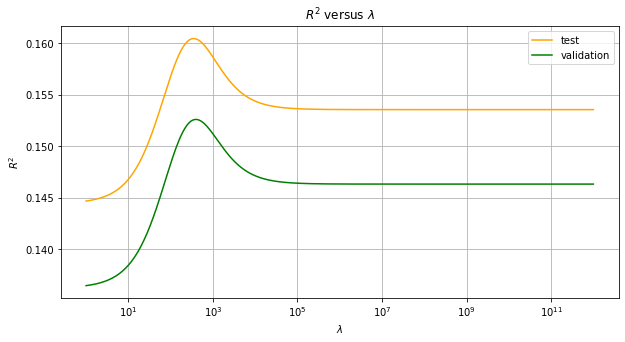

In [28]:
lists1 = sorted(inference_r2['val'].items()) 
x1, y1 = zip(*lists1) 
lists2 = sorted(inference_r2['test'].items()) 
x2, y2 = zip(*lists2) 
plt.figure(figsize = (10,5))
plt.plot(x2, y2, color='orange')
plt.plot(x1, y1, color='g')
plt.legend(['test', 'validation'])
plt.ylabel('$R^2$')
plt.xlabel('$\lambda$')
plt.title('$R^2$ versus $\lambda$')
plt.xscale('log')
plt.grid()
plt.show()

In [29]:
random_seed(10)

bootstrap_iters = range(500)
sample_idx = np.arange(X.shape[0])
parameters = list()

for idx in bootstrap_iters:

    bootstrap_idx = np.random.choice(sample_idx, size = 1000, replace = True)
    y_bootstrap = y[bootstrap_idx]
    X_bootstrap = X[bootstrap_idx]
    ridge = RidgeRegression(Lambda = 0)
    ridge.fit(X_bootstrap,y_bootstrap)
    parameters.append(ridge.parameters()) 
    
w_bootstrap = np.array(parameters)
w_mean = np.mean(w_bootstrap, axis=0)
w_std = np.std(w_bootstrap, axis=0)

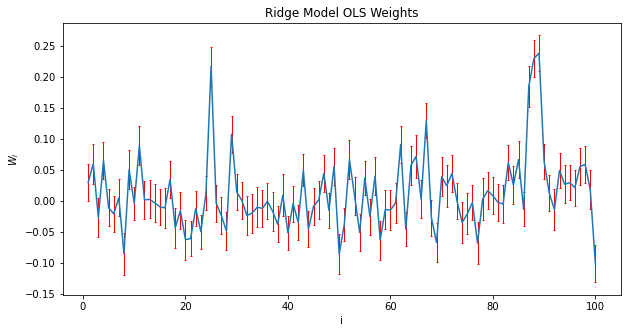

In [30]:
plt.figure(figsize = (10,5))
plt.errorbar(np.arange(1, 101),
             w_mean,
             yerr= w_std,
             ecolor='red',
             elinewidth=1,
             capsize=1)
plt.title('Ridge Model OLS Weights')
plt.xlabel('i')
plt.ylabel('$W_i$')
plt.show()

In [31]:
two_sided = 2
p_values = special.ndtr(- w_mean / w_std) * two_sided
alpha_level = 0.05
significants = np.argwhere(p_values < alpha_level).flatten()
print(f' Index of the parameters that are significantly different than 0: \n {significants}')
     

 Index of the parameters that are significantly different than 0: 
 [ 3 10 24 28 51 61 64 66 82 84 86 87 88 89 97]


In [32]:
random_seed(10)

bootstrap_iters = range(500)
sample_idx = np.arange(X.shape[0])
parameters = list()

for idx in bootstrap_iters:

    bootstrap_idx = np.random.choice(sample_idx, size = 1000, replace = True)
    y_bootstrap = y[bootstrap_idx]
    X_bootstrap = X[bootstrap_idx]
    ridge = RidgeRegression(Lambda = best_lambda)
    ridge.fit(X_bootstrap,y_bootstrap)
    parameters.append(ridge.parameters()) 
    
w_bootstrap = np.array(parameters)
w_mean = np.mean(w_bootstrap, axis=0)
w_std = np.std(w_bootstrap, axis=0)

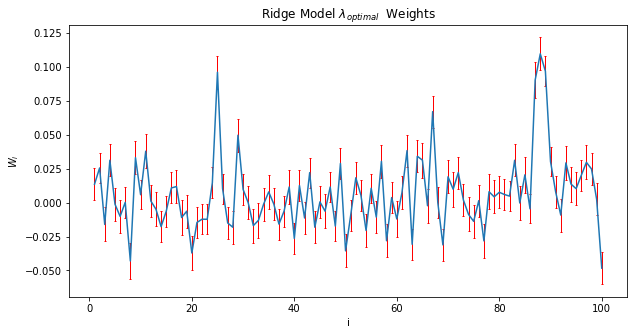

In [33]:
plt.figure(figsize = (10,5))
plt.errorbar(np.arange(1, 101),
             w_mean,
             yerr= w_std,
             ecolor='red',
             elinewidth=1,
             capsize=1)
plt.title('Ridge Model $\lambda_{optimal}$  Weights')
plt.xlabel('i')
plt.ylabel('$W_i$')
plt.show()

In [34]:
p_values = scipy.special.ndtr(- w_mean / w_std) * two_sided
significants = np.argwhere(p_values < alpha_level).flatten()
print(f' Index of the parameters that are significantly different than 0: \n {significants}')
     

 Index of the parameters that are significantly different than 0: 
 [ 1  3  8 10 24 28 42 48 56 61 63 64 66 82 86 87 88 89 92 96 97]


### Question 2

## Part A

In [44]:
f = h5py.File('hw3_data3.mat','r')
  
pop1 = np.array(
    f.get('pop1')
    )

pop2 = np.array(
    f.get('pop2')
    )

In [45]:
def bootstrap(sample:np.ndarray, bootstrap_iters:iter = range(10000), random_state:int = 11) -> np.ndarray:
    """
    
        Generate bootstrap samples using random sampling with replacement.
        
            Arguments:
                - sample (np.ndarray) : Sample to be bootstraped
                - bootstrap_iters (iterator object) : Specification of bootstrap iterations
                - random_state (int) : Random seed for reproducibility

            Returns:
                - bootstrap_samples (np.ndarray) : Bootstrapped array

    """
    random_seed(random_state)
    size = sample.shape[0]
    bootstrap_samples = list()

    for idx in bootstrap_iters:        
        bootstrap_idx = np.random.choice(np.arange(sample.shape[0]), size = size, replace = True)
        bootstrap_samples.append(sample[bootstrap_idx])
    
    return np.array(bootstrap_samples)

[]

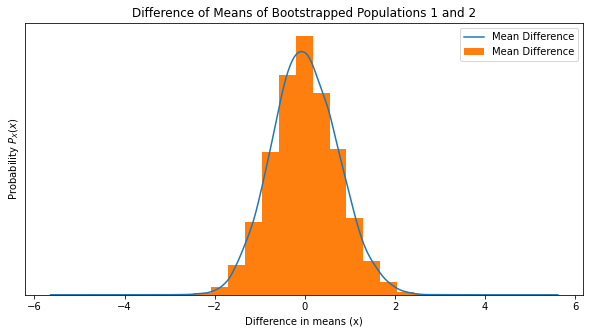

In [46]:
pop = np.vstack([pop1,pop2])
pop_bootstrap = bootstrap(pop)
sample_1 = pop_bootstrap[:,:len(pop1)].squeeze(2)
sample_2 = pop_bootstrap[:,len(pop1):].squeeze(2)
sample_1_bootstrap_mean = sample_1.mean(axis = 1)
sample_2_bootstrap_mean = sample_2.mean(axis = 1)
sample_diff_means = sample_1_bootstrap_mean - sample_2_bootstrap_mean
sample_mean_dist = pd.DataFrame()
sample_mean_dist['Mean Difference'] = sample_diff_means.flatten()
fig, ax = plt.subplots(figsize = (10,5))
sample_mean_dist.plot.kde(ax=ax, title='Difference of Means of Bootstrapped Populations 1 and 2')
sample_mean_dist.plot.hist(density=True, ax = ax, bins = 15)
ax.set_ylabel('Probability $P_X(x)$')
ax.set_xlabel('Difference in means (x)')
ax.grid(axis='y')
ax.set_yticks([])

[]

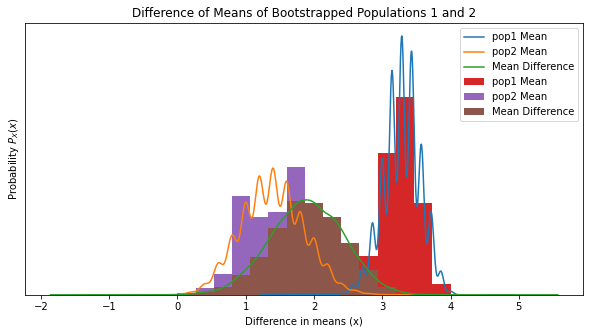

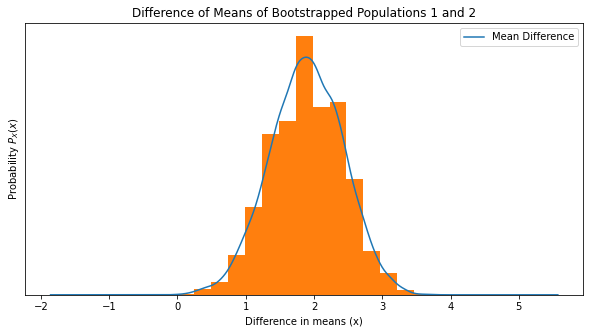

In [47]:
pop1_bootstrap = bootstrap(pop1)
pop2_bootstrap = bootstrap(pop2)
pop1_bootstrap_mean = np.mean(pop1_bootstrap, axis = 1)
pop2_bootstrap_mean = np.mean(pop2_bootstrap, axis = 1)

mean_dist = pd.DataFrame()
mean_dist['pop1 Mean'] = pop1_bootstrap_mean.flatten()
mean_dist['pop2 Mean'] = pop2_bootstrap_mean.flatten()
mean_dist['Mean Difference'] = pop1_bootstrap_mean - pop2_bootstrap_mean

fig, ax = plt.subplots(figsize = (10,5))
mean_dist.plot.kde(ax=ax, title='Difference of Means of Bootstrapped Populations 1 and 2')
mean_dist.plot.hist(density=True, ax = ax, bins = 15)
ax.set_ylabel('Probability $P_X(x)$')
ax.set_xlabel('Difference in means (x)')
ax.grid(axis='y')
ax.set_yticks([])


fig, ax = plt.subplots(figsize = (10,5))
mean_dist['Mean Difference'].plot.kde(ax=ax,legend = True, title='Difference of Means of Bootstrapped Populations 1 and 2')
mean_dist['Mean Difference'].plot.hist(density=True, ax = ax, bins = 15)
ax.set_ylabel('Probability $P_X(x)$')
ax.set_xlabel('Difference in means (x)')
ax.grid(axis='y')
ax.set_yticks([])

In [48]:
actual_diff_means = pop1.mean() - pop2.mean()
std_test = sample_mean_dist['Mean Difference'].std()
mean_test = sample_mean_dist['Mean Difference'].mean()

z_cal = (mean_test - actual_diff_means) / std_test
p_values = scipy.special.ndtr(z_cal) * two_sided

print('The two sided p-value is:', p_values)



The two sided p-value is: 0.01003287406404004


## Part B

(50,) (50,)
Mean correlation value: 0.5571443738567518
95% confidence interval of the correlation values: (0.5549693272197517, 0.5593194204937518)
Percentage of zero correlation values: 0.0


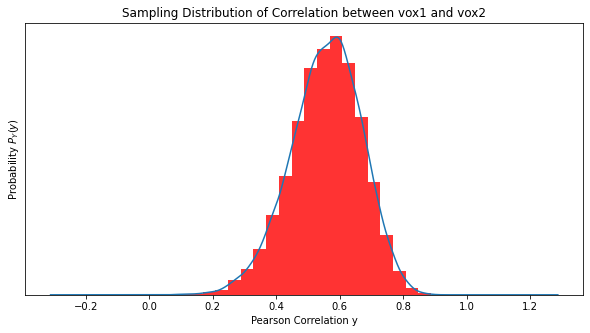

In [49]:
vox1 = np.array(
    f.get('vox1')
    ).flatten()

vox2 = np.array(
    f.get('vox2')
    ).flatten()


print(
    vox1.shape,
    vox2.shape
)

vox1_bootstrap = bootstrap(vox1)
vox2_bootstrap = bootstrap(vox2)

def corr(X: list or np.ndarray,Y: list or np.ndarray) -> list:
    """
    
        Given the X,Y distributions, computes the Pearson Correlation element wise.
        
            Arguments:
                - X (list or np.ndarray) : First distribution
                - Y (list or np.ndarray) : Second distribution

            Returns:
                - pearson_corrs (list[float]) : Computed correlations element wise

    
    """
    assert X.shape == Y.shape, 'Dimension Mismatch!'
    return [scipy.stats.pearsonr(X[i], Y[i])[0] for i in range(X.shape[0])]

corr_bootstrap = corr(vox1_bootstrap,vox2_bootstrap)

fig, ax = plt.subplots(figsize = (10,5))
pd.Series(corr_bootstrap).plot.kde(ax=ax, legend = False, title='Sampling Distribution of Correlation between vox1 and vox2')
pd.Series(corr_bootstrap).plot.hist(density=True, ax = ax, bins = 20, alpha = 0.8,color = 'red')
ax.set_ylabel('Probability $P_Y(y)$')
ax.set_xlabel('Pearson Correlation y')
ax.grid(axis='y')
ax.set_yticks([])
# Thanks to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def confidence_interval(data: list or np.ndarray, confidence:float=0.95) -> tuple:
    """
    
        Given the distribution and confidence level, computes the confidence interval.
            
            Arguments:
                - data (list or np.ndarray) : Input distribution
                - confidence (float) : confidence level in the range [0,1]
            
            
            Returns:
                - confidence_level (tuple[np.ndarray]) : lower, upper limits respectively
        
        
    
    """
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h
 
def _confidence_interval(data, confidence=0.95):    
    return scipy.stats.t.interval(confidence, len(data)-1, loc=np.mean(data), scale=st.sem(data))

corr_mean = np.mean(corr_bootstrap)
lower, upper = confidence_interval(corr_bootstrap,confidence=0.95)
print('Mean correlation value:', corr_mean)
print(f'95% confidence interval of the correlation values: {lower, upper}')

is_corr_zero = np.argwhere(corr_bootstrap == 0)
corr_zero_percentage = 100 * is_corr_zero.shape[0] / 10000
print('Percentage of zero correlation values:', corr_zero_percentage)

## Part C

The one sided p-value is: 3.812065700707869e-05


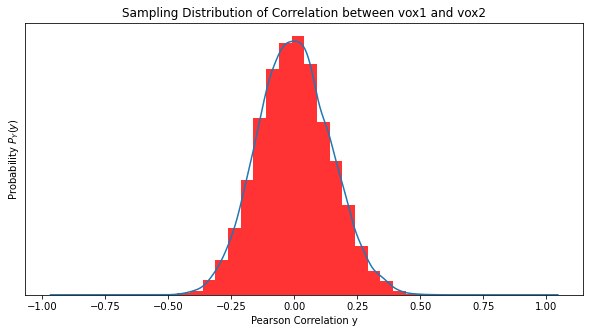

In [50]:
vox1_ind = bootstrap(vox1, range(10000), random_state=42)
vox2_ind = bootstrap(vox2, range(10000), random_state=21)

_corr_ind = corr(vox1_ind,vox2_ind)

corr_ind = pd.Series(_corr_ind)


fig, ax = plt.subplots(figsize = (10,5))
corr_ind.plot.kde(ax=ax, legend = False, title='Sampling Distribution of Correlation between vox1 and vox2')
corr_ind.plot.hist(density=True, ax = ax, bins = 20, alpha = 0.8,color = 'red')
ax.set_ylabel('Probability $P_Y(y)$')
ax.set_xlabel('Pearson Correlation y')
ax.grid(axis='y')
ax.set_yticks([])


actual_corr, _ = scipy.stats.pearsonr(vox1,vox2)
mean_corr = corr_ind.mean()
std_corr = corr_ind.std()
z_score = mean_corr - actual_corr
z_score /= std_corr
p_value = scipy.special.ndtr(z_score)
print('The one sided p-value is:', p_value)

## Part D

(20,) (20,)
The two sided p-value is: 0.000356527118064005


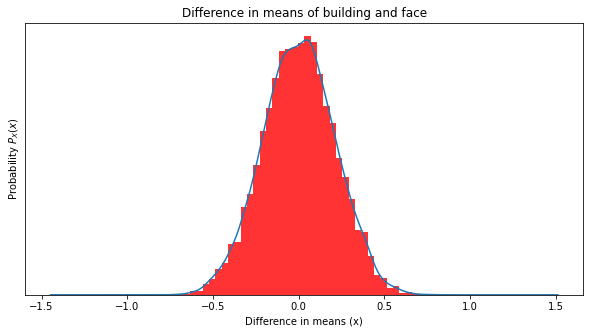

In [52]:
building = np.array(f.get('building')).flatten()

face = np.array(f.get('face')).flatten()

print(
    building.shape,
    face.shape   
)

random_seed(31)

assert building.shape[0] == face.shape[0],'Dimensionality Mismatch!'

sample_size = np.arange(building.shape[0])

_mean_diff = list()
bootstrap_iters  = np.arange(10000)

for ii in bootstrap_iters:
    
    resample = []
    
    for jj in sample_size:
        
        bootstrap_idx = np.random.choice(np.arange(building.shape[0]), replace = True)
        options = [0] * 2
        _option = building[jj] - face[jj]
        options.append(_option)
        _option = face[jj] - building[jj]
        options.append(_option)
        resample.append(np.random.choice(options))
        
    _mean_diff.append(np.mean(resample))

    
mean_diff = pd.Series(_mean_diff)
fig, ax = plt.subplots(figsize = (10,5))
mean_diff.plot.kde(ax=ax, legend = False, title='Difference in means of building and face')
mean_diff.plot.hist(density=True, ax = ax, bins = 40, alpha = 0.8, color = 'red')
ax.set_ylabel('Probability $P_X(x)$')
ax.set_xlabel('Difference in means (x)')
ax.grid(axis='y')
ax.set_yticks([])


x_actual = np.mean(building) - np.mean(face)
mean = mean_diff.mean()
std = mean_diff.std()
z_score = mean - x_actual
z_score /= std
p_value = scipy.special.ndtr(- z_score) * two_sided
print('The two sided p-value is:', p_value)

## Part E

The one sided p-value is: Mean Difference    0.00844
dtype: float64


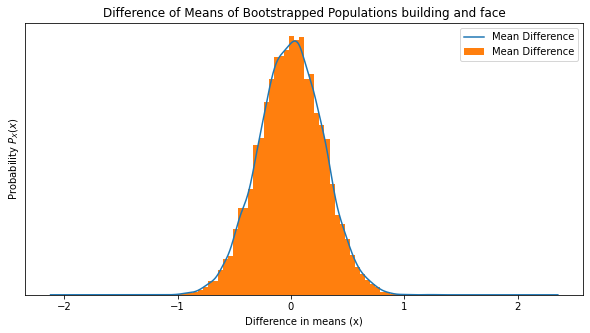

In [53]:
arr_stack = np.hstack((building, face))
arr_bootstrap = bootstrap(arr_stack)
samples1 = arr_bootstrap[:, :len(building)]
samples2 = arr_bootstrap[:, len(building):]
means1 = np.mean(samples1, axis=1)
means2 = np.mean(samples2, axis=1)
sample_diff_means = means1 - means2


sample_mean_dist = pd.DataFrame()
sample_mean_dist['Mean Difference'] = sample_diff_means.flatten()
fig, ax = plt.subplots(figsize = (10,5))
sample_mean_dist.plot.kde(ax=ax, title='Difference of Means of Bootstrapped Populations building and face')
sample_mean_dist.plot.hist(density=True, ax = ax, bins = 50)
ax.set_ylabel('Probability $P_X(x)$')
ax.set_xlabel('Difference in means (x)')
ax.grid(axis='y')
ax.set_yticks([])



x_actual = np.mean(building) - np.mean(face)
mean = sample_mean_dist.mean()
std = sample_mean_dist.std()
z_score = mean - x_actual
z_score /= std
p_value = scipy.special.ndtr(- z_score) * two_sided
print('The two sided p-value is:', p_value)